## Examples

In [1]:
# Imports

# import importlib, sys
# importlib.reload(sys.modules['utils'])

import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [66]:
# Parameters
im_size = 128 # side length of image; discretizes [-2, 2] x [-2, 2]
grid_size = im_size/4
seed = 12345
alpha = 0.01
f = lambda x: np.sin(x) # Testing function
lap_f = lambda x: np.sin(x) # Laplacian of f

### Experiment 1: Comparing different metrics

In [154]:
# Parameters
r = .75 # radius
rad = r*grid_size # radius in pixels

# Normalization constants for computing the L1 and L2 norm, respectively
L1_factor = (4*r*grid_size**2)
L2_factor = (np.sqrt(4*r)*grid_size)

#### Compare metrics

In [155]:
# Generate evenly spaced data for plotting distances
num_samples = 121
thetas = np.linspace(-np.pi, np.pi, num_samples)
data, _ = gen_data_s1(None, im_size, rad, thetas = thetas)

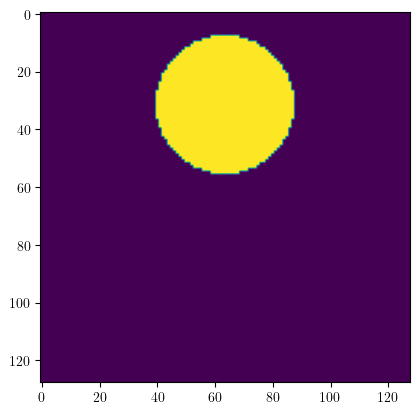

In [156]:
# Sanity check
plt.imshow(data[0])

In [157]:
# Compute norms
l1_norms = np.array([ np.sum(np.abs(d - data[num_samples//2])) for d in data])/L1_factor
l2_norms = np.array([ np.linalg.norm(d - data[num_samples//2]) for d in data])/L2_factor

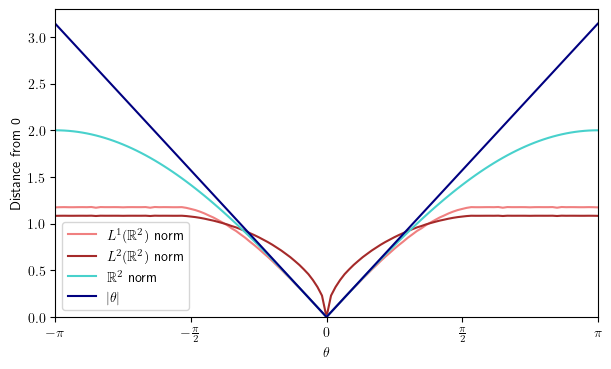

In [158]:
# Plot
fig, ax = plt.subplots(figsize = (7, 4))

ax.plot(thetas, l1_norms, label = r'$L^1(\mathbb{R}^2)$ norm', color = 'lightcoral')
ax.plot(thetas, l2_norms, label = r'$L^2(\mathbb{R}^2)$ norm', color = 'brown')
ax.plot(thetas, r2_norm(thetas, 0), label = r'$\mathbb{R}^2$ norm', color = 'mediumturquoise')
ax.plot(thetas, dtheta(thetas, 0), label = r'$|\theta|$', color = 'navy')

ax.set_xlabel(r'$\theta$')
ax.set_xticks(ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.set_ylabel('Distance from 0')
ax.set_xlim(left = thetas[0], right = thetas[-1])
ax.set_ylim(bottom = 0)
ax.legend()

#### Pointwise convergence

In [ ]:
# Parameters
Ns = [2000, 4000, 8000, 16000, 32000] # Sample sizes to test

thetas = np.linspace(-np.pi, np.pi, 25) # Angles for plotting
data_for_plotting, _ = gen_data_s1(None, im_size, rad, thetas = thetas)

metrics = ['L2', 'L1', 'R2', 'dg']
met_to_str = {
    'L2' : r'$L^2(\mathbb{R}^2)$ norm',
    'L1' : r'$L^1(\mathbb{R}^2)$ norm',
    'R2' : r'$\mathbb{R}^2$ norm',
    'dg' : r'$d_g$'
}

In [ ]:
# Compute discrete Laplacians
L1_disc_lap = {} # with the L1 norm
L2_disc_lap = {} # with the L2 norm (for convenience, we compute it using the L1 norm and Laplace kernel)
R2_disc_lap = {} # with the R2 norm
actual_disc_lap = {} # with the geodesic distance

# Sample data
max_N = np.max(Ns)
L1_norms = np.empty((len(thetas), max_N))
rng = np.random.default_rng(seed = seed)
sample_thetas = rng.random(size = max_N)* 2 * np.pi
data, _ = gen_data_s1(None, im_size, rad, thetas = sample_thetas)

# Compute all L1 norms
for j, th in enumerate(thetas):
    diffs = data-data_for_plotting[j]
    L1_norms[j] = np.array(np.sum(np.abs(diffs), axis = (1, 2)))/L1_factor

In [28]:
for i, N in enumerate(Ns):
    # Parameters
    eps = 2*N**(-1/(3 + alpha))
    gkernel = lambda x: np.exp(-np.square(x)/(2*eps)) # Gaussian kernel
    lkernel = lambda x: np.exp(-x/(2*eps)) # Laplace kernel
    factor = 4*np.pi/(eps*(2*np.pi*eps)**(1/2)*N) # Normalization factor 2vol(M)/(\eps*(2\pi\eps)^{1/2}n); see Theorem 3.1

    # Initialize
    L1_disc_lap[N] = np.empty_like(thetas)
    L2_disc_lap[N] = np.empty_like(thetas)
    R2_disc_lap[N] = np.empty_like(thetas)
    actual_disc_lap[N] = np.empty_like(thetas)

    # Compute discrete Laplacian
    for j, th in enumerate(thetas):
        L1_disc_lap[N][j] = factor*np.dot(gkernel(L1_norms[j, :N]),  f(th)-f(sample_thetas[:N]))
        L2_disc_lap[N][j] = factor*np.dot(lkernel(L1_norms[j, :N]), f(th)-f(sample_thetas[:N]))
        R2_disc_lap[N][j] = factor*np.dot(gkernel(r2_norm(sample_thetas[:N], th)), f(th)-f(sample_thetas[:N]))
        actual_disc_lap[N][j] = factor*np.dot(gkernel(dtheta(sample_thetas[:N], th)), f(th)-f(sample_thetas[:N]))

    print(f"Sample size = {N} complete")

Sample size = 2000 complete
Sample size = 4000 complete
Sample size = 8000 complete
Sample size = 16000 complete
Sample size = 32000 complete


In [29]:
# Optional: save
np.save('L1_disc_lap.npy', L1_disc_lap)
np.save('L2_disc_lap.npy', L2_disc_lap)
np.save('R2_disc_lap.npy', R2_disc_lap)
np.save('dg_disc_lap.npy', actual_disc_lap)
np.save('L1_norms.npy', L1_norms)

# L1_disc_lap = np.load('L1_disc_lap.npy', allow_pickle = True).item() # Reloading example

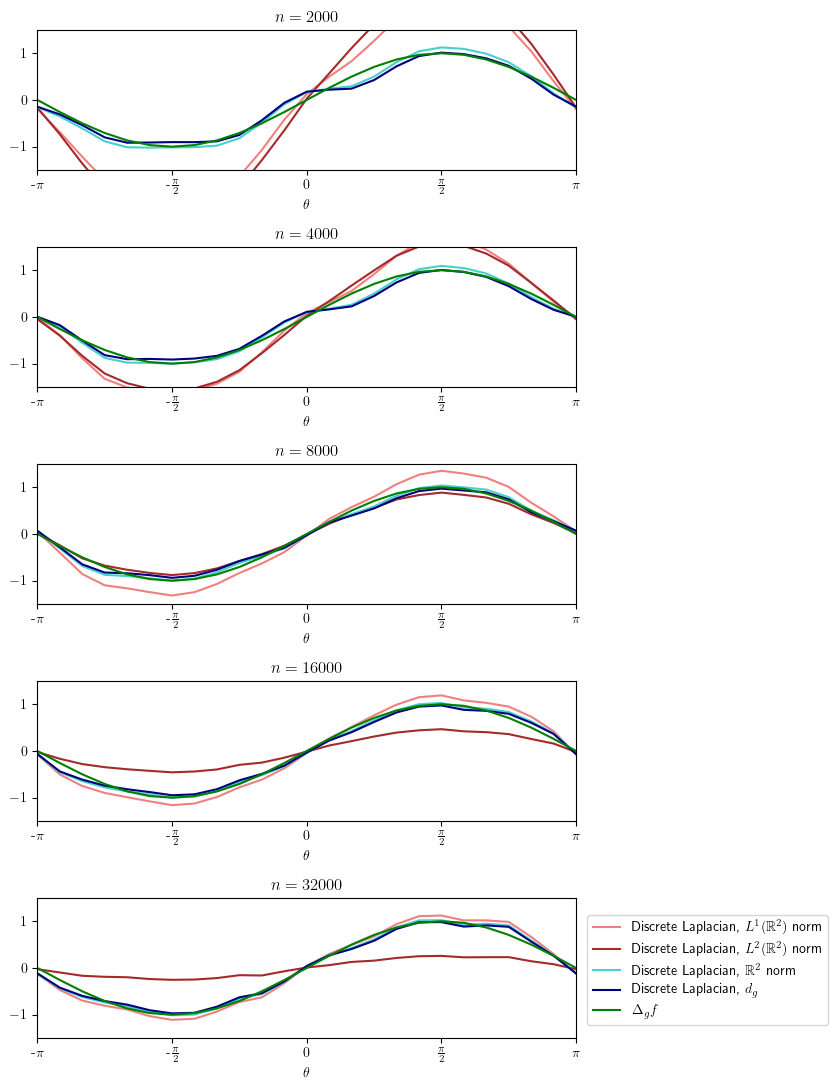

In [60]:
# Plot
fig, axs = plt.subplots(len(Ns), figsize = (6, 11))
label = 'Discrete Laplacian, '
for i, N in enumerate(Ns):
    ax = axs[i]
    ax.set_title(r'$n = {{{}}}$'.format(N))
    ax.plot(thetas, L1_disc_lap[N], color = 'lightcoral', label = label + met_to_str['L1'])
    ax.plot(thetas, L2_disc_lap[N], color = 'brown', label = label + met_to_str['L2'])
    ax.plot(thetas, R2_disc_lap[N], color = 'mediumturquoise', label = label + met_to_str['R2'])
    ax.plot(thetas, actual_disc_lap[N], color = 'navy', label = label + met_to_str['dg'])
    ax.set_xlim([-np.pi, np.pi])
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlabel(r'$\theta$')
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$',r'-$\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

    ax.plot(thetas, lap_f(thetas), color = 'green', label = r'$\Delta_gf$')

    if i == 0:
        fig.legend(bbox_to_anchor=(1.4, .17))

plt.tight_layout()

#### Laplacian eigenmap embeddings

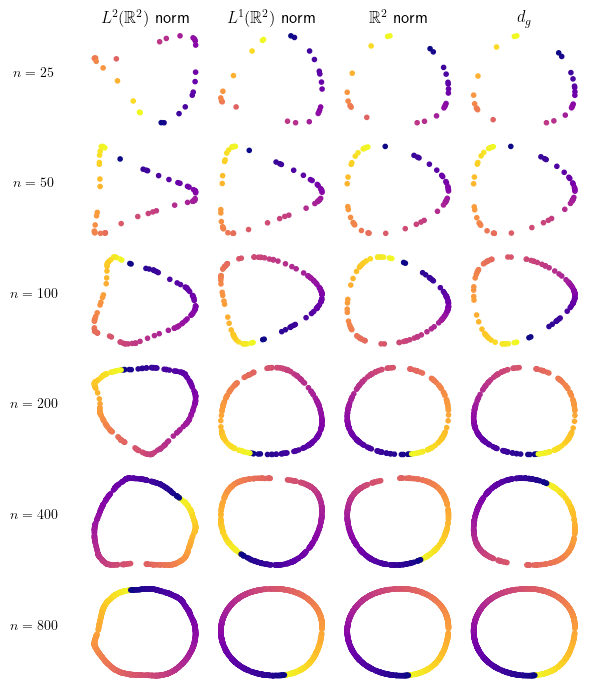

In [ ]:
Ns = [25, 50, 100, 200, 400, 800]
W = {} # for storing weight matrices
fig, axs = plt.subplots(nrows = len(Ns), ncols = len(metrics), figsize = (6, 7))

for i, N in enumerate(Ns):
    eps = 2*N**(-1/(3 + alpha))
    gkernel = lambda x: np.exp(-np.square(x)/(2*eps))
    lkernel = lambda x: np.exp(-x/(2*eps))

    rng = np.random.default_rng(seed = seed)
    sample_thetas = rng.random(size = N)* 2 * np.pi
    data, _ = gen_data_s1(None, im_size, rad, thetas = sample_thetas)

    data = np.reshape(data, (data.shape[0], -1))
    pwdist = pdist(data, metric = 'minkowski', p = 1.)/L1_factor
    W[('L1', N)] = gkernel(pwdist)
    W[('L2', N)] = lkernel(pwdist)

    sample_thetas = np.expand_dims(sample_thetas, axis = 1)
    W[('R2', N)] = gkernel(pdist(sample_thetas, metric = r2_norm))
    W[('dg', N)] = gkernel(pdist(sample_thetas, metric = dtheta))

    for j, met in enumerate(metrics):
        # Compute eigenvectors
        temp = squareform(W[(met, N)])
        _, eigvecs = eigh(temp, subset_by_index=[temp.shape[0]-3, temp.shape[0]-2], b = np.diag(np.sum(temp, axis = 1)))

        # Plot
        ax = axs[i, j]
        if i == 0:
            ax.set_title(met_to_str[met])
        ax.scatter(eigvecs[:, 1], eigvecs[:, 0], marker = '.', cmap = "plasma", c = sample_thetas)
        ax.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
        ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft = False)

        if j == 0:
            ax.set_ylabel(r'$n = {{{}}}$'.format(N), rotation = 0, labelpad = 40)

plt.tight_layout()

### Experiment 2: Changing radii

#### Compare metrics

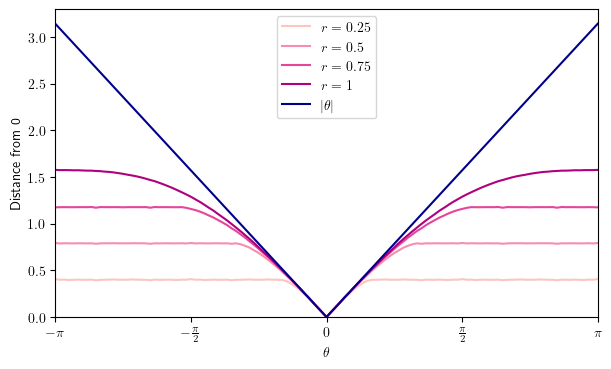

In [ ]:
# Parameters
num_samples = 121
thetas = np.linspace(-np.pi, np.pi, num_samples)
radii = [.25, .5, .75, 1]
fig, ax = plt.subplots(figsize = (7, 4))
colors = plt.cm.RdPu(np.linspace(.25,.75,len(radii)))

for i, r in enumerate(radii):
    rad = r*grid_size
    L1_factor = (4*r*grid_size**2)

    # Generate data
    data, _ = gen_data_s1(None, im_size, rad, thetas = thetas)

    # Compute L1 norms
    l1_norms = np.array([ np.sum(np.abs(d - data[num_samples//2])) for d in data])/L1_factor

    ax.plot(thetas, l1_norms, label = r'$r = {{{}}}$'.format(r), color = colors[i])

ax.plot(thetas, np.abs(thetas), label = r'$|\theta|$', color = 'darkblue')
ax.set_xlabel(r'$\theta$')
ax.set_xticks(ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.set_ylabel('Distance from 0')
ax.set_xlim(left = thetas[0], right = thetas[-1])
ax.set_ylim(bottom = 0)

ax.legend()

#### Pointwise convergence

In [114]:
thetas = np.linspace(-np.pi, np.pi, 25) # Angles for plotting

L1_norms = {}
disc_lap = {}

# Sample data
# max_N = np.max(Ns)
max_N = 128000
rng = np.random.default_rng(seed = seed)
sample_thetas = rng.random(size = max_N)* 2*np.pi

In [ ]:
for k, r in enumerate(radii):
    print(f'Radius = {r}')
    rad = r*grid_size
    L1_factor = (4*r*grid_size**2)
    data_for_plotting, _ = gen_data_s1(None, im_size, rad, thetas = thetas) # Data for plotting
    data, _ = gen_data_s1(None, im_size, rad, thetas = sample_thetas) # Randomly sampled data

    # Compute L1 norms
    for j, th in enumerate(thetas):
        diffs = data-data_for_plotting[j]
        L1_norms[(r, j)] = np.array(np.sum(np.abs(diffs), axis = (1, 2)))/L1_factor

Radius = 0.25
Radius = 0.5
Radius = 0.75
Radius = 1


In [ ]:
# Optional: save
np.save('L1_norms_exp2.npy', L1_norms)

In [138]:
Ns = [2000, 8000, 32000, 128000] # Sample sizes to test
L1_norms = np.load('L1_norms_exp2.npy', allow_pickle=True).item()
# Compute discrete Laplacian
for k, r in enumerate(radii):
    for i, N in enumerate(Ns):
        eps = 2*N**(-1/(3 + alpha))
        gkernel = lambda x: np.exp(-np.square(x)/(2*eps)) # Gaussian kernel
        factor = 4*np.pi/(eps*(2*np.pi*eps)**(1/2)*N)
        
        # Compute discrete Laplacian
        disc_lap[(r, N)] = np.empty_like(thetas)
        for j, th in enumerate(thetas):
            disc_lap[(r, N)][j] = factor*np.dot(gkernel(L1_norms[(r, j)][:N]), f(th)-f(sample_thetas[:N]))

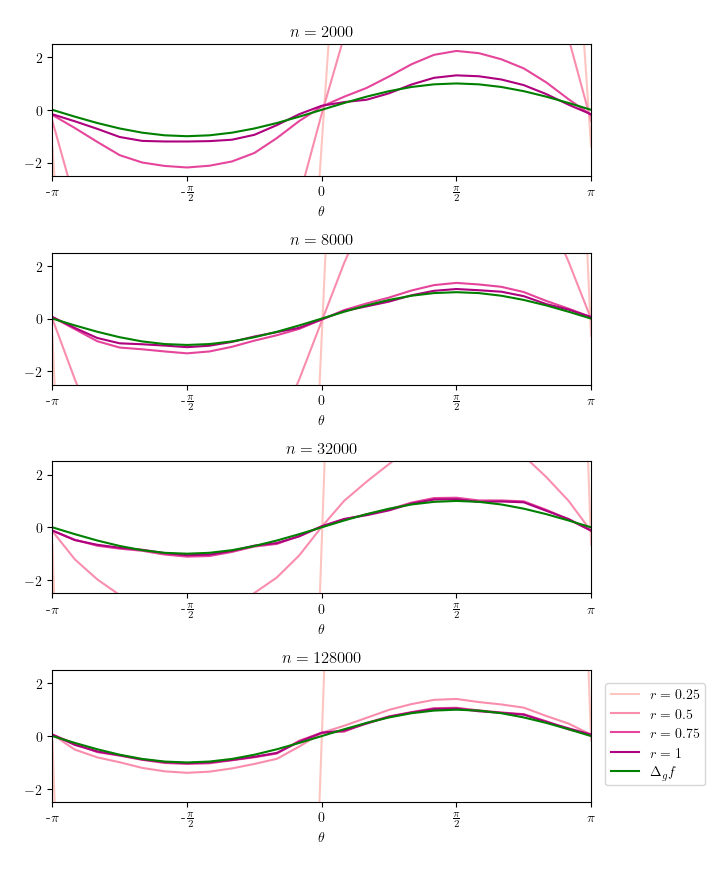

In [148]:
fig, axs = plt.subplots(len(Ns), figsize = (6, 8.5))
subfigs = fig.subfigures(len(Ns), 1)
for k, r in enumerate(radii):
    for i, N in enumerate(Ns):

        ax = axs[i]

        if i == 0:
            ax.plot(thetas, disc_lap[(r, N)], label = r'$r = {{{}}}$'.format(r), color = colors[k])
        else:
            ax.plot(thetas, disc_lap[(r, N)], color = colors[k])

        if k == len(radii) - 1:
            ax.set_xlim([-np.pi, np.pi])
            ax.set_xlabel(r'$\theta$')
            ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$',r'-$\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
            ax.set_title(r'$n = {{{}}}$'.format(N))
            ax.set_ylim([-2.5, 2.5])

            if i == 0:
                ax.plot(thetas, lap_f(thetas), color = 'green', label = r'$\Delta_g f$')
            else:
                ax.plot(thetas, lap_f(thetas), color = 'green')
                   
fig.legend(bbox_to_anchor=(1.17, .215))
plt.tight_layout()

In [136]:
np.save('disc_lap_exp2.npy', disc_lap)

#### Laplacian eigenmap embeddings

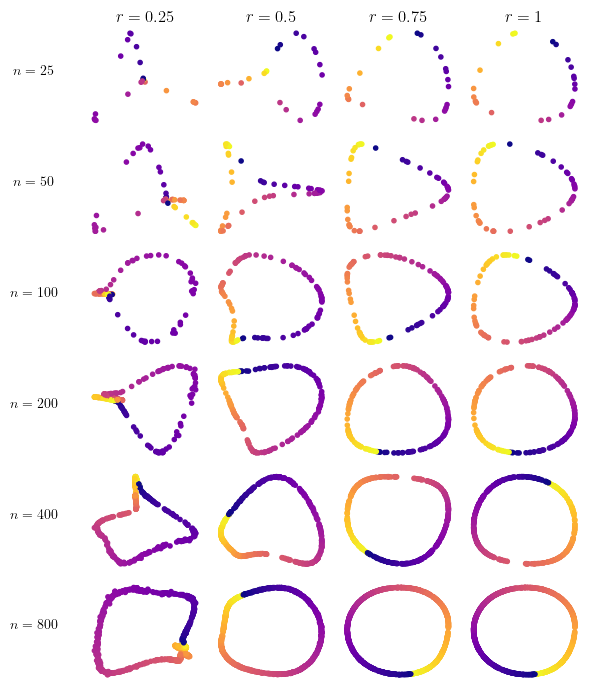

In [159]:
Ns = [25, 50, 100, 200, 400, 800]
W = {}
fig, axs = plt.subplots(nrows = len(Ns), ncols = len(radii), figsize = (6, 7))

for i, N in enumerate(Ns):
    eps = 2*N**(-1/(3 + alpha))
    gkernel = lambda x: np.exp(-np.square(x)/(2*eps))
    factor = 4*np.pi/(eps*(2*np.pi*eps)**(1/2)*N)

    # Sample angles
    rng = np.random.default_rng(seed = seed)
    sample_thetas = rng.random(size = N)* 2*np.pi

    for j, r in enumerate(radii):
        rad = r*grid_size
        L1_factor = (4*r*grid_size**2)

        # Get data
        data, _ = gen_data_s1(None, im_size, rad, thetas = sample_thetas)
        data = np.reshape(data, (data.shape[0], -1))

        # Construct weight matrix
        pwdist = pdist(data, metric = 'minkowski', p = 1.)/L1_factor
        W[(r, N)] = gkernel(pwdist)

        # Compute eigenvectors
        temp = squareform(W[(r, N)])
        _, eigvecs = eigh(temp, subset_by_index=[temp.shape[0]-3, temp.shape[0]-2], b = np.diag(np.sum(temp, axis = 1)))

        # Plot
        ax = axs[i, j]
        if i == 0:
            ax.set_title(r'$r = {{{}}}$'.format(r))
        ax.scatter(eigvecs[:, 1], eigvecs[:, 0], marker = '.', cmap = "plasma", c = sample_thetas)
        ax.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
        ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft = False)

        if j == 0:
            ax.set_ylabel(r'$n = {{{}}}$'.format(N), rotation = 0, labelpad = 40)

plt.tight_layout()